In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request

In [2]:
# [트레이닝 셋 불러오기]
# 0,3,6 데이터 200개씩
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/jaehosung/ml4se_codes/main/exercise07"
    "/sample-images_01.txt",
    "images.txt ",
)

('images.txt ', <http.client.HTTPMessage at 0x1cecf791e50>)

In [3]:
# 트레이닝 셋 할당, 이미지 1개 28픽셀x28픽셀 (size=(600,784))
df_training_set = pd.read_csv("images.txt", sep=",", header=None)
print(df_training_set.iloc[0].values.reshape(28, 28))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 

In [4]:
# 베르누이 확률 분포
def bernoulli(x, mu):  # x (size = (784,)), mu (size = (784,))
    p = np.prod(mu[x == 1]) * np.prod(1 - mu[x == 0])
    return p

In [5]:
# 생성기 시각화
def draw_generator(axs_generators, iter_num, mu):
    for k in range(K):
        axs_generators[k, iter_num].set_xticks([])
        axs_generators[k, iter_num].set_yticks([])
        axs_generators[k, iter_num].imshow(mu[k].reshape(28, 28), cmap=plt.cm.gray_r)

In [6]:
# 파라미터 설정
N = len(df_training_set)  # 데이터 개수 (600)
K = 3  # 생성기 개수
iteration_num = 10  # 생성기 생성 반복 횟수

In [7]:
# 분류 결과의 시각화 함수
def draw_result(mu, r_argmax, axs):
    for c in range(K):
        # 이미지 생성기 시각화
        axs[c, 0].set_xticks([])
        axs[c, 0].set_yticks([])
        axs[c, 0].imshow(mu[c].reshape(28, 28), cmap=plt.cm.gray_r)

        # K번째 이미지 생성기에 속하는 데이터
        i = 1
        for j in range(len(r_argmax)):
            if r_argmax[j] == c:
                axs[c, i].set_xticks([])
                axs[c, i].set_yticks([])
                axs[c, i].imshow(
                    df_training_set.iloc[j].values.reshape(28, 28),
                    cmap=plt.cm.gray_r
                )
                i += 1
                if i > 6:
                    break

In [8]:
# E(expectation) step
# 각 이미지가 k 이미지 생성기를 통해서 얻어질 가능성 계산
def calc_expectation(df_training_set, pi, mu):
    # r_n_k: 데이터가 k번째 이미지 생성기로부터 이미지가 얻어질 가능성
    r_n_k = np.empty(shape=(0, K))

    # r_n_k 계산하기. N개의 데이터에 대해서 차례대로 계산, x_n (size=(784,))
    for _, x_n in df_training_set.iterrows():

        r_i_k = np.array([])

        for k in range(K):  # K개의 이미지 생성기에 대해서 차례대로 계산
            p_mu_k = bernoulli(x_n, mu[k])  # p_u_k : p_u_k(x_n)

            # r_i_k_numer(numerator) 계산: pi * p_mu_k(x_n)
            r_i_k_numer = pi[k] * p_mu_k

            # r_i_k_denom(denominator) 계산: sigma(pi * P_mu_k)
            r_i_k_denom = 0.0
            for kk in range(K):
                r_i_k_denom += pi[kk] * bernoulli(x_n, mu[kk])

                # r_i_k = r_i_k_numer / r_i_k_denom
            r_i_k = np.hstack((r_i_k, r_i_k_numer / r_i_k_denom))
        r_n_k = np.vstack((r_n_k, r_i_k))  # r_n_k (size=(N,K))
    return r_n_k

In [9]:
# M(maximization) step
# 새로운 이미지 생성기 mu와 이미지 생성기를 선택할 확률 pi 계산
def calc_new_generators(df_training_set, r_n_k, pi, K):
    # mu_numer(numerator) (size = (K, 284))
    mu_numer = np.zeros(28 * 28 * K).reshape(K, 28 * 28)
    for k in range(K):  # K개의 이미지 생성기에 대해서 차례대로 계산
        mu_denom = r_n_k[:, k].sum()  # mu_denom = sigma_n(r_n_k) (dtype: float)
        pi[k] = mu_denom / N  # pi_k = sigma(n_k) / N
        # N개의 데이터에 대해서 차례대로 계산
        for i, x_n in df_training_set.iterrows():
            mu_numer[k] += x_n * r_n_k[i][k]  # mu_k 분모: sigma_n(r_n_k * x_n)
        # mu_k = sigma_n(r_n_k * x_n) / sigma(r_n_k)
        mu[k] = mu_numer[k] / mu_denom
    return mu, pi

iter_num 0
iter_num 1
iter_num 2
iter_num 3
iter_num 4
iter_num 5
iter_num 6
iter_num 7
iter_num 8
iter_num 9


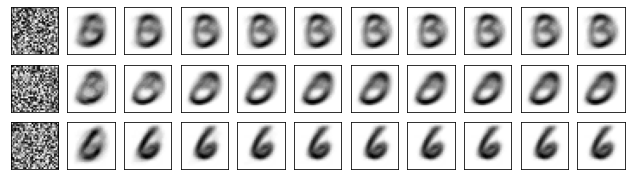

In [10]:
# EM 알고리즘을 사용하여 이미지 생성기 만들기

# 변수 초기화
pi = np.full(K, 1 / K)  # pi: K번째 이미지 생성기를 선택할 확률 (size=(K,))
# mu: K개의 이미지 생성기 (size=(K,784))
mu = (np.random.rand(28 * 28 * K) * 0.5 + 0.25).reshape(K, 28 * 28)
# r_n_k: n번째 이미지가 k번째 이미지 생성기로부터 이미지가 얻어질 가능성,
# r_n_k_final: 계산 반복을 끝냈을 때 r_n_k 값
r_n_k_final = np.array([])

# 생성기의 변화 시각화
fig_generators, axs_generators = plt.subplots(
    K, iteration_num + 1,
    figsize=(iteration_num+1,K)
)  # axs_generators (size=(K, iteration_num+1))

# 이미지 생성기 초기값 시각화
draw_generator(axs_generators, 0, mu)

for iter_num in range(iteration_num):
    print("iter_num %d" % iter_num)

    # 각 이미지가 k 이미지 생성기를 통해서 얻어질 가능성 계산
    r_n_k = calc_expectation(df_training_set, pi, mu)
    # 새로운 이미지 생성기 mu와 이미지 생성기를 선택할 확률 pi 계산
    mu, pi = calc_new_generators(df_training_set, r_n_k, pi, K)

    # 이미지 생성기 시각화
    draw_generator(axs_generators, iter_num + 1, mu)

    # 계산 반복을 끝냈을 때 r_n_k 값 저장
    r_n_k_final = r_n_k.copy()

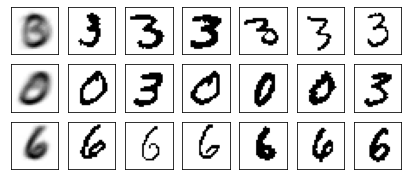

In [11]:
# 분류 결과 표시
fig_result, axs_result = plt.subplots(K, 7, figsize = (7,K))
r_argmax = list(r_n_k_final.argmax(axis=1))  # 가장 높은 확률로 소속될 생성기의 인덱스
draw_result(mu, r_argmax, axs_result)

In [12]:
# 분류된 데이터 시각화
def draw_classified_result(generator_num):
    col_max = 20
    cond = df_r_n_k.idxmax(axis=1) == generator_num
    data_num = df_r_n_k[cond].shape[0]
    row_max = int(data_num/ col_max) + 1

    fig_classified_result, axs_classified_result = plt.subplots(
        row_max, col_max, figsize=(col_max, row_max)
    )
    i = 0
    df_r_n_k.sort_values(generator_num, axis=0,
                                         ascending=False).copy()
    df_r_n_k_iter = df_r_n_k[cond].copy()
    print("number of data classified by generator %d: %d"%(generator_num,data_num))
    for idx, line in df_r_n_k_iter.iterrows():
        if i < col_max * row_max:
            row = int(i / col_max)
            col = i % col_max
            axs_classified_result[row][col].imshow(
                df_training_set.iloc[idx].values.reshape(28, 28),
                cmap=plt.cm.gray_r
            )
            i = i + 1
    for row in range(row_max):
        for col in range(col_max):
            axs_classified_result[row][col].set_xticks([])
            axs_classified_result[row][col].set_yticks([])
    fig_classified_result.tight_layout()

In [13]:
r_n_k_final
df_r_n_k = pd.DataFrame(r_n_k_final)

number of data classified by generator 0: 214


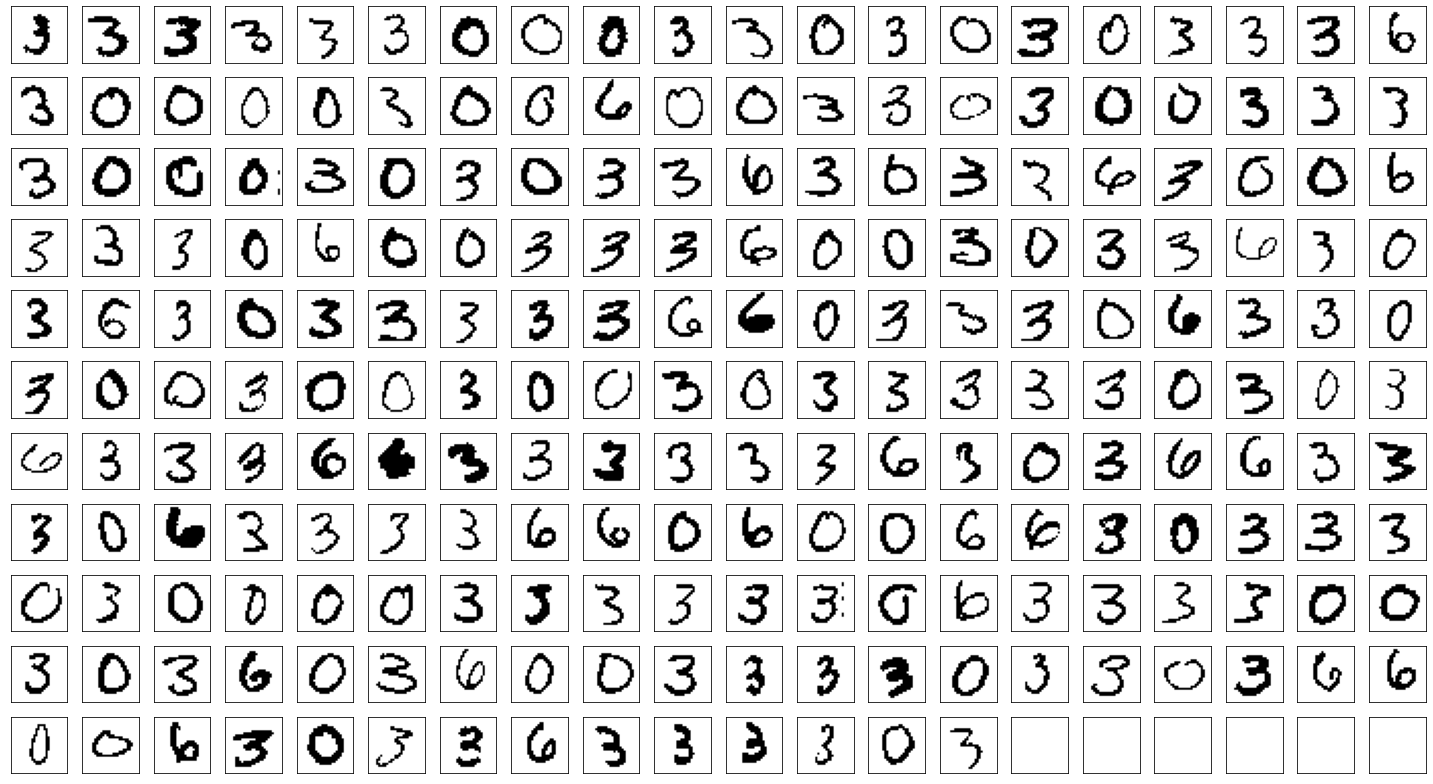

In [14]:
# 0번째 생성기로 분류된 데이터
df_r_n_k = pd.DataFrame(r_n_k_final)
draw_classified_result(0)

number of data classified by generator 1: 202


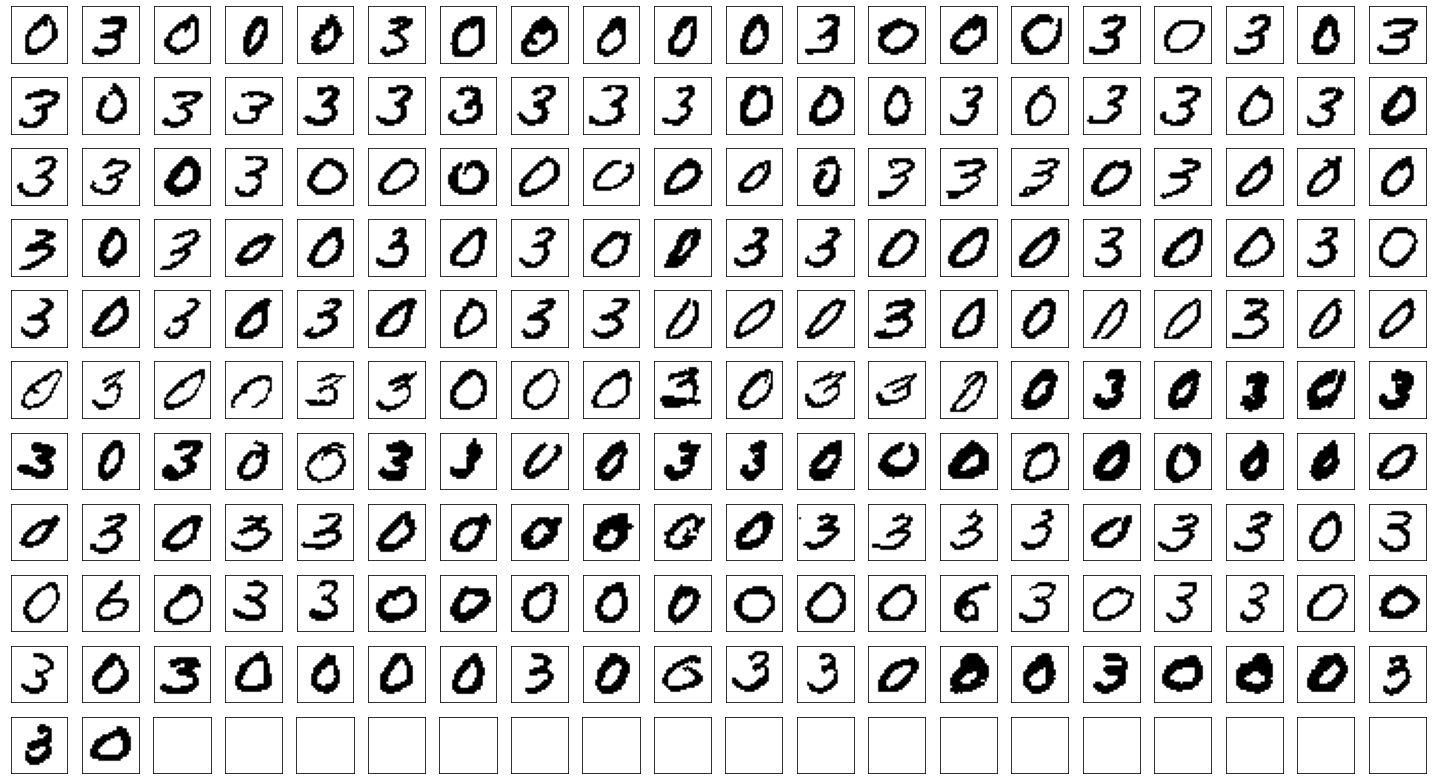

In [15]:
# 1번째 생성기로 분류된 데이터
draw_classified_result(1)

number of data classified by generator 2: 184


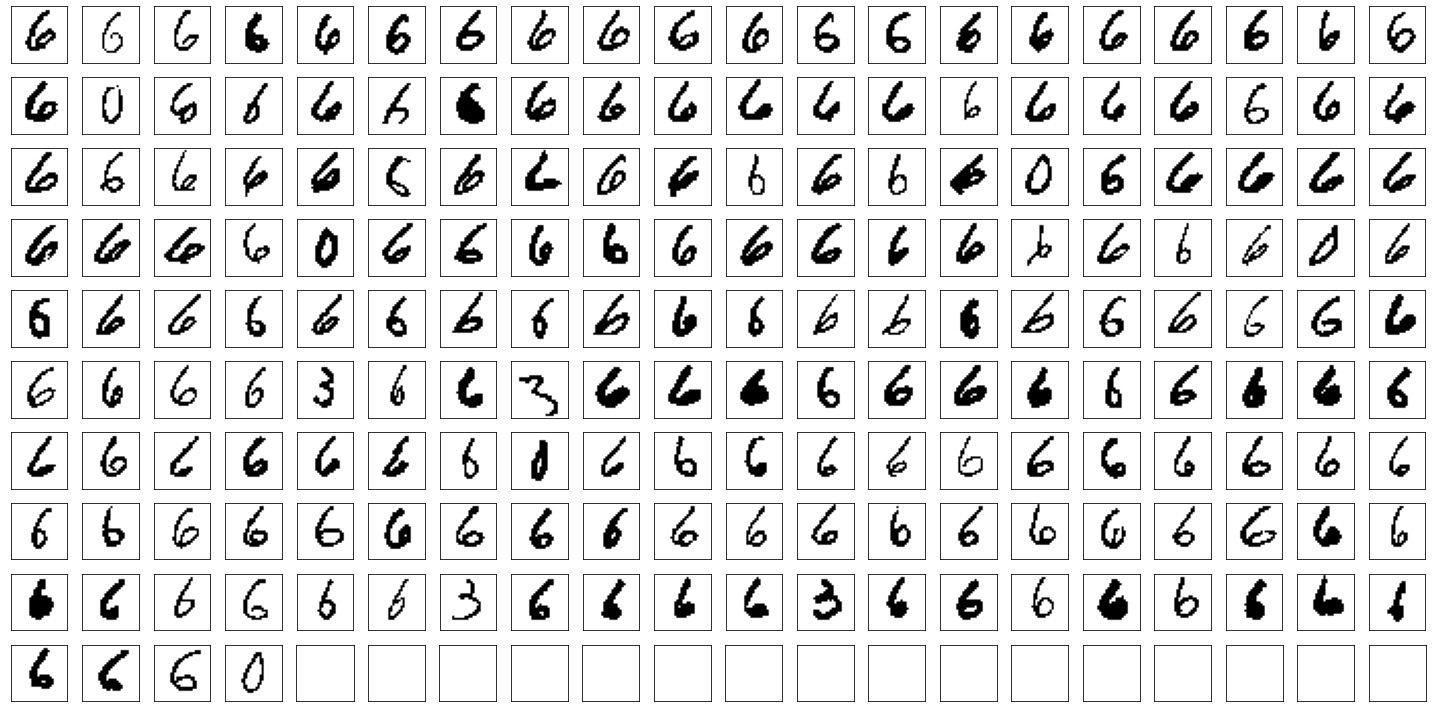

In [16]:
# 2번째 생성기로 분류된 데이터
draw_classified_result(2)
